100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.42it/s]


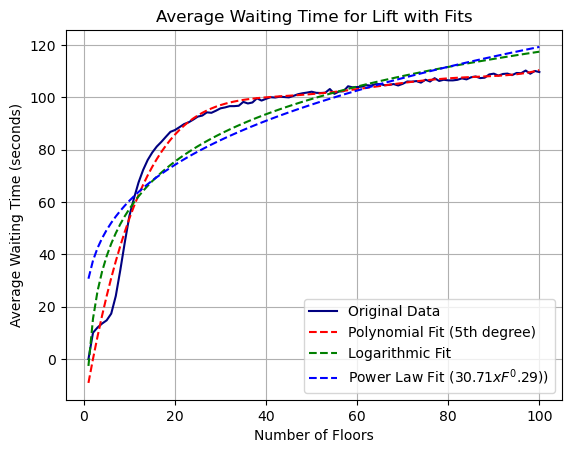

Time taken to run the code: 7.6228203773498535 seconds


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import njit
from scipy.optimize import curve_fit
import time

start_time = time.time()

# Simulation parameters
max_floors = 200  # Maximum number of floors to simulate
elevator_capacity = 10
elevator_speed = 2  # time to move one floor
door_time = 5  # time to open/close doors
lam = 0.1  # Lambda for Poisson distribution (average number of arrivals per floor per time step)
max_people_per_floor = 10
time_steps = 100
num_simulations = 10000  # Number of simulations to average over

@njit
def run_simulation(num_floors):
    # Using arrays to store people waiting and elevator passengers
    people_waiting = np.zeros((num_floors, max_people_per_floor, 2), dtype=np.int32)  # (destination, arrival_time)
    num_waiting = np.zeros(num_floors, dtype=np.int32)  # number of people waiting per floor
    elevator_position = 1  # Start at floor 1
    elevator_passengers = np.zeros((elevator_capacity, 2), dtype=np.int32)  # (destination, arrival_time)
    num_passengers = 0
    waiting_times = np.zeros(time_steps * num_floors * max_people_per_floor, dtype=np.int32)
    waiting_time_count = 0

    for t in range(time_steps):
        # Checking for new arrivals using Poisson distribution
        for floor in range(num_floors):
            arrivals = np.random.poisson(lam)  # Poisson-distributed number of arrivals
            for _ in range(arrivals):
                if num_waiting[floor] < max_people_per_floor:
                    destination = np.random.randint(1, num_floors + 1)
                    if destination != (floor + 1):  # Avoid choosing the current floor as destination
                        arrival_time = t
                        people_waiting[floor, num_waiting[floor], 0] = destination
                        people_waiting[floor, num_waiting[floor], 1] = arrival_time
                        num_waiting[floor] += 1

        # Loading people into the elevator at the current floor
        if num_passengers < elevator_capacity:
            while num_passengers < elevator_capacity and num_waiting[elevator_position - 1] > 0:
                elevator_passengers[num_passengers] = people_waiting[elevator_position - 1, 0]
                num_passengers += 1
                num_waiting[elevator_position - 1] -= 1
                # Shift people waiting queue on that floor
                people_waiting[elevator_position - 1, :-1] = people_waiting[elevator_position - 1, 1:]

        # Moving the elevator and dropping passengers
        if num_passengers > 0:
            destination = elevator_passengers[0, 0]
            if elevator_position < destination:
                elevator_position += 1
            elif elevator_position > destination:
                elevator_position -= 1
            else:
                # Dropping off passengers at the current floor
                to_drop = 0
                for i in range(num_passengers):
                    if elevator_passengers[i, 0] == elevator_position:
                        waiting_time = t - elevator_passengers[i, 1]
                        waiting_times[waiting_time_count] = waiting_time
                        waiting_time_count += 1
                        to_drop += 1

                # Shifting passengers array
                if to_drop > 0:
                    elevator_passengers[:num_passengers - to_drop] = elevator_passengers[to_drop:num_passengers]
                    num_passengers -= to_drop

        t += elevator_speed + door_time

    # Calculate and return the average waiting time
    average_waiting_time = np.mean(waiting_times[:waiting_time_count]) if waiting_time_count > 0 else 0
    return average_waiting_time

# Running simulations for each number of floors and averaging the results
floor_range = np.arange(1, max_floors + 1)
average_waiting_times = np.zeros(max_floors)

for num_floors in tqdm(range(1, max_floors + 1)):
    waiting_times = np.zeros(num_simulations)
    for i in range(num_simulations):
        waiting_time = run_simulation(num_floors)
        waiting_times[i] = waiting_time
    average_waiting_times[num_floors - 1] = np.mean(waiting_times)

# Plotting the original results
plt.plot(floor_range, average_waiting_times, color='navy', label="Original Data")

# Polynomial fit (2nd degree)
poly_coeffs = np.polyfit(floor_range, average_waiting_times, 5)
poly_fit = np.polyval(poly_coeffs, floor_range)
plt.plot(floor_range, poly_fit, 'r--', label='Polynomial Fit (5th degree)')

# Logarithmic fit
log_coeffs = np.polyfit(np.log(floor_range), average_waiting_times, 1)
log_fit = log_coeffs[0] * np.log(floor_range) + log_coeffs[1]
plt.plot(floor_range, log_fit, 'g--', label='Logarithmic Fit')

# Power law fit using scipy's curve_fit
def power_law(x, a, b):
    return a * np.power(x, b)

power_law_params, _ = curve_fit(power_law, floor_range, average_waiting_times)
power_fit = power_law(floor_range, *power_law_params)
plt.plot(floor_range, power_fit, 'b--', label=f'Power Law Fit (${power_law_params[0]:.2f} x F^{power_law_params[1]:.2f})$)')

# Adding labels and legend
plt.xlabel('Number of Floors')
plt.ylabel('Average Waiting Time (seconds)')
plt.title('Average Waiting Time for Lift')
plt.grid(True)
plt.legend()  # Show the legend
plt.show()

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken to run the code: {elapsed_time} seconds")
